In [1]:
import os
import glob

import mne
import numpy as np
import pandas as pd
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)

In [2]:
sfreq = 100
n_jobs = 30

In [10]:
files = glob.glob('/home/jovyan/competition/data/validation_final/*100_hz_raw.fif.gz')

In [11]:
len(files)

800

In [7]:
def do(file, sfreq):
    raw = mne.io.read_raw_fif(file, verbose='error', preload=True)
    raw.drop_channels(ch_names='Cz')
    # raw = raw.apply_function(lambda x: np.clip(x, -800/1e6, 800/1e6)) # clip to -800/+800 microvolt
    # raw.set_eeg_reference('average')
    raw.resample(sfreq=sfreq)
    file = file.replace('_raw.fif.gz', f'_{sfreq}_hz_raw.fif.gz')
    raw.save(file)

    means = raw.get_data(units='uV').mean(axis=1)
    stds = raw.get_data(units='uV').std(axis=1)
    chs = raw.ch_names
    df = pd.DataFrame({'mean': means, 'std': stds}, index=chs)
    ext = files[0][files[0].find('.'):]
    df.to_csv(file.replace(ext, '_stats.csv'))

In [8]:
_ = Parallel(n_jobs=n_jobs)(delayed(do)(file, sfreq) for file in files)

In [9]:
print("hi")

hi


In [3]:
import sys
sys.path.insert(0, '/home/jovyan/braindecode/')

In [4]:
# download data https://filesender.renater.fr/?s=download&token=e1de0ec4-09bc-4194-b85b-59830cb04af3
# download test data from https://codalab.lisn.upsaclay.fr/competitions/8336

# Path to training data
train_path = "/home/jovyan/competition/data/training/"
# Path to testing data (public test set)
test_path = "/home/jovyan/competition/data/testing/"
train_subj = 1200  # use 10 instead of 1200 training subjects, for demonstration purpose
test_subj = 400  # use 10 instead of 400 testing subjects, for demonstration purpose

train_raws, test_raws = {}, {}
for condition in ["EC", "EO"]:
    train_raws[condition] = []
    test_raws[condition] = []
    train_subjs = list(range(1, train_subj + 1))
    for s in train_subjs:
        fname = f"subj{s:04}_{condition}_{sfreq}_hz_raw.fif.gz"
        raw = mne.io.read_raw(train_path + fname, preload=False, verbose='error')
        train_raws[condition].append(raw)
    test_subjs = list(range(1201, 1201 + test_subj))
    for s in test_subjs:
        fname = f"subj{s:04}_{condition}_{sfreq}_hz_raw.fif.gz"
        raw = mne.io.read_raw(test_path + fname, preload=False, verbose='error')
        test_raws[condition].append(raw)

In [5]:
from braindecode.datasets import BaseConcatDataset, BaseDataset

In [6]:
target_name = 'age'

In [59]:
train_ec = BaseConcatDataset([
    BaseDataset(raw, target_name=target_name) for raw in train_raws['EC']
])
train_eo = BaseConcatDataset([
    BaseDataset(raw, target_name=target_name) for raw in train_raws['EO']
])

/home/jovyan/braindecode/braindecode/datasets/base.py:131: UserWarning: 'age' not in description. '__getitem__'will fail unless an appropriate target is added to description.
  warnings.warn(f"'{name}' not in description. '__getitem__'"


In [60]:
meta = pd.read_csv(train_path + "train_subjects.csv", index_col=0)

In [61]:
train_ec.set_description(meta)
train_ec.set_description({'condition': ['EC'] * len(train_ec.datasets)})
train_ec.set_description({'path': [ds.raw.filenames[0] for ds in train_ec.datasets]})

In [62]:
train_eo.set_description(meta)
train_eo.set_description({'condition': ['EO'] * len(train_eo.datasets)})
train_eo.set_description({'path': [ds.raw.filenames[0] for ds in train_eo.datasets]})

In [63]:
train = BaseConcatDataset([train_ec, train_eo])

In [64]:
train.description

,id,age,condition,path
0,1.0,8.581679,EC,/home/jovyan/competition/data/training/subj000...
1,2.0,17.324321,EC,/home/jovyan/competition/data/training/subj000...
2,3.0,11.059890,EC,/home/jovyan/competition/data/training/subj000...
3,4.0,6.027720,EC,/home/jovyan/competition/data/training/subj000...
4,5.0,11.306297,EC,/home/jovyan/competition/data/training/subj000...
...,...,...,...,...
2395,1196.0,7.979237,EO,/home/jovyan/competition/data/training/subj119...
2396,1197.0,9.107232,EO,/home/jovyan/competition/data/training/subj119...
2397,1198.0,14.886835,EO,/home/jovyan/competition/data/training/subj119...
2398,1199.0,9.102213,EO,/home/jovyan/competition/data/training/subj119...


In [65]:
import pickle

In [66]:
with open('/home/jovyan/competition/data/training/train_100_hz.pkl', 'rb') as f:
    train100 = pickle.load(f)

In [67]:
train100.description

,id,age,condition,subject,path
0,1.0,8.581679,EC,1,/home/jovyan/competition/data/training/subj000...
1,2.0,17.324321,EC,2,/home/jovyan/competition/data/training/subj000...
2,3.0,11.059890,EC,3,/home/jovyan/competition/data/training/subj000...
3,4.0,6.027720,EC,4,/home/jovyan/competition/data/training/subj000...
4,5.0,11.306297,EC,5,/home/jovyan/competition/data/training/subj000...
...,...,...,...,...,...
2395,1196.0,7.979237,EO,1196,/home/jovyan/competition/data/training/subj119...
2396,1197.0,9.107232,EO,1197,/home/jovyan/competition/data/training/subj119...
2397,1198.0,14.886835,EO,1198,/home/jovyan/competition/data/training/subj119...
2398,1199.0,9.102213,EO,1199,/home/jovyan/competition/data/training/subj119...


In [69]:
pd.testing.assert_frame_equal(train.description, train100.description[['id', 'age', 'condition', 'path']])

In [51]:
test_ec = BaseConcatDataset([
    BaseDataset(raw) for raw in test_raws['EC']
])
test_eo = BaseConcatDataset([
    BaseDataset(raw) for raw in test_raws['EO']
])

In [52]:
test_ec.set_description(test_subjs)
test_ec.set_description({'condition': ['EC'] * len(test_ec.datasets)})
test_ec.set_description({'path': [ds.raw.filenames[0] for ds in test_ec.datasets]})
test_eo.set_description(test_subjs)
test_eo.set_description({'condition': ['EO'] * len(test_ec.datasets)})
test_eo.set_description({'path': [ds.raw.filenames[0] for ds in test_eo.datasets]})

In [53]:
test = BaseConcatDataset([test_ec, test_eo])

In [54]:
test.description

,0,condition,path
0,1201,EC,/home/jovyan/competition/data/testing/subj1201...
1,1202,EC,/home/jovyan/competition/data/testing/subj1202...
2,1203,EC,/home/jovyan/competition/data/testing/subj1203...
3,1204,EC,/home/jovyan/competition/data/testing/subj1204...
4,1205,EC,/home/jovyan/competition/data/testing/subj1205...
...,...,...,...
795,1596,EO,/home/jovyan/competition/data/testing/subj1596...
796,1597,EO,/home/jovyan/competition/data/testing/subj1597...
797,1598,EO,/home/jovyan/competition/data/testing/subj1598...
798,1599,EO,/home/jovyan/competition/data/testing/subj1599...


In [26]:
import pickle

In [27]:
with open(train_path + f'train_{sfreq}_hz.pkl', 'wb') as f:
    pickle.dump(train, f)

In [29]:
with open(test_path + f'test_{sfreq}_hz.pkl', 'wb') as f:
    pickle.dump(test, f)

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)

Text(0.5, 1.0, 'Train ages')

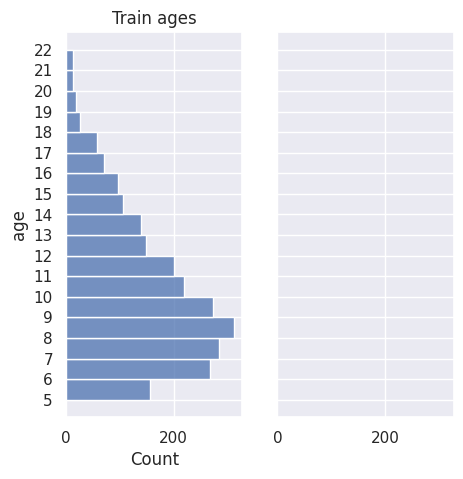

In [32]:
fig, ax_arr = plt.subplots(1, 2, figsize=(5,5), sharex=True, sharey=True)
bins = bins=range(5, 23)
ax = ax_arr[0]
ax = sns.histplot(data=train.description, y='age', bins=bins, ax=ax)
ax.set_yticks(bins);
ax.set_yticklabels(bins);
ax.set_title('Train ages')

# ax = ax_arr[1]
# ax = sns.histplot(data=test.description, y='age', bins=bins, ax=ax)
# ax.set_title('Valid ages')